<a href="https://colab.research.google.com/github/IamAnubhav08/BMICalculator/blob/main/BrainTumorMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Importing all the necessary libraries**
  
---

We first import numpy, torch, torchvision and all the prerequisite files to start formulating our Convolutional neural network model. For loading the image file, we import *DataLoader* and for the data pre-processing step, we import *transforms* so that we can first convert the loaded images into a tensor(as we are using PyTorch here)and also - normalize, crop, and manipulate the data as per our choice.
Finally *matplotlib* is imported so that we can plot our results in a graph.



In [2]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn 
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch.autograd import Variable
import pathlib
import matplotlib.pyplot as plt

# **2. Selecting the device**
We know that having a gpu will help the model train faster than on a cpu, so we explicitly check for the availability of a gpu and assign to a 'device' variable.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Here we print the device and it outputs** *'cuda'* **which suggests that there is an availability of a GPU** 

In [4]:
print(device)


cuda


# **3. Importing the images from kaggle**


---
In this step we gain access to the dataset through an API command which we run ans unzip the file in our working directory './' or '/content'.


In [ ]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anubhavsantra","key":"f05e8e22a18452d06fd8e65939693bef"}'}

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


 81% 121M/149M [00:00<00:00, 152MB/s] 
100% 149M/149M [00:00<00:00, 156MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('brain-tumor-mri-dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

# **4. Checking the data structure**


---
Here we print the number of files in our root directory and also print the number of classes that our present in our training dataset. Finally, we get 4 classes, namely - "Glioma", "Meningioma", "NoTummor", "Pituitary". Our final target will be to train a model which is correctly going to classify MRI scanned images into these 4 classes.

In [ ]:
data_dir= "./"
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/Training")
print(classes)

['.config', 'Training', 'Testing', 'kaggle.json', 'brain-tumor-mri-dataset.zip', 'sample_data']
['glioma', 'meningioma', 'notumor', 'pituitary']


# **5. Checking the dimensions of each Image in our dataset**

---
Using the ***Image*** library imported from **PIL**, we print the height and the width of a single image. The images are of the dimension 512 x 512 which is convenent for us to work with and will not cause much of feature losses when we apply transforms like torch.Resize(), etc. 


In [ ]:
from PIL import Image

#get image
filepath = "/content/Training/glioma/Tr-glTr_0000.jpg"
img = Image.open(filepath)

#get height and width
height = img.height
width = img.width

#display height and width
print("Height of image: ", height)
print("Width of the image: ", width)


Height of image:  512
Width of the image:  512


# **6. Data Pre-Processing**

---
Perhaps, this is one of the most import steps in our working procedure as this is going to be the input data to our training network.
Pytorch uses tensors for image classification and hence we are going to compose three transformation processes in which we will do the following:

*   **Resize the image to a dimension of 256 x 256**
*   **Apply the transforms.ToTensor() function to convert the image     into a tensor**
*   **Normalize the image tensor -** Normalization of the image simply means that the values for each channel will be calculated using the formula - image = (image - mean)/standard_deviation. We pass mean and std parameters each as 0.5 which means that the values willlie in [-1,1]. This helps CNN models in training and converging to a minima faster.






In [ ]:
#Applying Transforms
transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])

])

# **7. Using DataLoader**


---
Two sets of data are obtained - train_loader, test_loader and we apply our transforms and set the batch size for the training set to be 32 and batch size of the test data as 1. Finally we set shuffle = True to ensure that the data is well randomized and not biased.



In [ ]:
#DataLoader
train_path = "/content/Training"
test_path = "/content/Testing"

train_loader = DataLoader(torchvision.datasets.ImageFolder(train_path, transform = transformer),
                          batch_size = 32, shuffle = True
)
test_loader = DataLoader(torchvision.datasets.ImageFolder(test_path, transform =transformer),
                         batch_size = 1, shuffle = True
)


for images,labels in train_loader:
  print("Image shape: ", images.shape),
  print("Labels shape: ", labels.shape),
  print("Class labels of first 15 examples: ", labels[:15])
  break




Image shape:  torch.Size([32, 3, 256, 256])
Labels shape:  torch.Size([32])
Class labels of first 15 examples:  tensor([1, 2, 3, 3, 0, 0, 2, 2, 0, 2, 3, 0, 1, 2, 3])


In [ ]:
#Categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


# **8. Defining the Convolutional Neural Network**

---
This is the core of the problem, where we manually implement the AlexNet architecture which takes 3 x 256 x 256 image in batches of 32 for training. The stride, padding and kernel_size is set and the input and output dimensions of the inenr Convolutional layers are also set according to the problem. Finally, an average pool is done after which we have a fully conected layer which outputs 4 classes.


In [ ]:
#Defining the Network


class AlexNet(torch.nn.Module):

    def __init__(self, num_classes=4):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            #
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            #
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            #
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            #
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        outputs = self.classifier(x)
        return outputs


In [ ]:
model = AlexNet(num_classes=4).to(device)

# **9. A special optimization**

---
After this line of code was implemented the accuracy proved to be much better than what it was showing previously. Here the pre-trained AlexNet model is stored into an object and the weights are set to the final optimized weights for the pretrained model. Only after initializing the weights according to this, we will perform gradien descent. 


In [39]:
# amodel=models.alexnet(pretrained=True)
model_wts=amodel.state_dict()


In [38]:
print(amodel)
# amodel.classifier[6] = nn.Linear(4096,4)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
model.load_state_dict(model_wts)

<All keys matched successfully>

# **10. HyperParameter Tuning**

---

We set the hyperparameters to certain values that provides a better training accuracy for our model and use stochastic gradient descent as our function and use a cross-entropy loss function. A step-scheduler is used so that the learning rate of the gradient descent algorithm decreases with 10 successful iterations. Number of epochs is set to 30.


In [ ]:
#HyperParameters

optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
loss_function = nn.CrossEntropyLoss()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=.1)
num_of_epochs = 30

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

5712 1311


# **11. Training the CNN model**

---
We will now finally train our model for the set number of epochs and note the accuracy and save the model that gives us the best accuracy on the test set.


*   After looping through the train_loader object we enter the training phase of the model with model.train(). 
*   Inside the loop, we start calculating the gradients and pass our training images to the model defined before.
*  We get the predictions and then calculate the loss using our cross-entropy function.
*   For the next iteration, we set the gradients to be zero so that the previous gradients are discarded and a new computation starts. After this, a backpropagation is done to find minimas with respect to the model parameters.

Now, after the training is complete and we are done optimizing the parameters, we evaluate the predictions of the test set and calculate the accuracy. This process will be done according to the number of epochs.

After this, we save the model which gives us the best accuracy on the test set.









In [41]:
#Model Training and saving the best Model

best_accuracy = 0.0
for epoch in range(num_of_epochs):
  #Evaluation and training on training dataset
  model.train()
  running_loss=0.0
  running_correct=0.0
  correct=0.0
  for images,labels in train_loader:
       images = images.to(device)
       labels = labels.to(device)
       with torch.set_grad_enabled(True):
         outputs=model(images)
         _,preds=torch.max(outputs,1)
         loss=loss_function(outputs,labels)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       
       running_loss +=loss.item()*images.size(0)
       running_correct +=torch.sum(preds==labels.data)
  step_lr_scheduler.step()  
  train_accuracy=running_correct/train_count
  train_loss=running_loss/train_count


  #Evaluating on the test set

  model.eval()
  test_accuracy=0.0

  for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        outputs  = model(images)
        _,preds=torch.max(outputs,1)
        correct += (preds == labels.cuda(device)).sum().item()
  test_accuracy = 100*(correct/test_count)


  print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
  if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    


Epoch: 0 Train Loss: 0.6208441909454784 Train Accuracy: tensor(0.7717, device='cuda:0') Test Accuracy: 79.86270022883295
Epoch: 1 Train Loss: 0.382010689135693 Train Accuracy: tensor(0.8645, device='cuda:0') Test Accuracy: 85.65980167810832
Epoch: 2 Train Loss: 0.3262290562234339 Train Accuracy: tensor(0.8832, device='cuda:0') Test Accuracy: 80.39664378337147
Epoch: 3 Train Loss: 0.29593064757037896 Train Accuracy: tensor(0.8932, device='cuda:0') Test Accuracy: 87.26163234172387
Epoch: 4 Train Loss: 0.25773261103476464 Train Accuracy: tensor(0.9077, device='cuda:0') Test Accuracy: 88.48207475209765
Epoch: 5 Train Loss: 0.23393151848590008 Train Accuracy: tensor(0.9172, device='cuda:0') Test Accuracy: 89.77879481311976
Epoch: 6 Train Loss: 0.20526657274373772 Train Accuracy: tensor(0.9273, device='cuda:0') Test Accuracy: 90.77040427154843
Epoch: 7 Train Loss: 0.20011516610363952 Train Accuracy: tensor(0.9326, device='cuda:0') Test Accuracy: 90.31273836765827
Epoch: 8 Train Loss: 0.19939

In [42]:
obj = torch.load("/content/best_checkpoint.model")

In [43]:
print(obj)

OrderedDict([('features.0.weight', tensor([[[[ 1.1827e-01,  9.3680e-02,  9.4999e-02,  ...,  5.5209e-02,
            2.1004e-02,  4.9346e-02],
          [ 7.4499e-02,  3.8530e-02,  5.2557e-02,  ...,  2.5115e-02,
           -1.1834e-02,  3.5712e-03],
          [ 7.4971e-02,  3.8256e-02,  5.4453e-02,  ...,  4.3041e-02,
            9.6659e-03,  1.2634e-02],
          ...,
          [ 9.2704e-02,  1.0334e-01,  6.7223e-02,  ..., -2.0280e-01,
           -1.2858e-01, -1.1250e-01],
          [ 4.3124e-02,  6.4517e-02,  3.5845e-02,  ..., -2.0263e-01,
           -1.1403e-01, -1.0751e-01],
          [ 4.6999e-02,  6.2162e-02,  2.4434e-02,  ..., -1.1868e-01,
           -9.5880e-02, -8.4225e-02]],

         [[-7.3000e-02, -5.8385e-02, -8.1097e-02,  ..., -1.2163e-03,
           -2.5880e-02,  2.4855e-02],
          [-6.9425e-02, -6.7971e-02, -7.6787e-02,  ..., -4.5546e-03,
           -3.0937e-02,  9.8901e-03],
          [-9.9970e-02, -8.6113e-02, -1.0569e-01,  ..., -2.7142e-02,
           -2.3336e-02,

In [21]:
training_loss = np.array([0.6208441909454784,0.382010689135693,0.3262290562234339,0.29593064757037896 ,0.25773261103476464 , 0.23393151848590008,0.20526657274373772,0.20011516610363952, 0.1993947534167132, 0.20004217322467088,0.19666684944840038, 0.19538408110873037,0.19406067427633858 ,0.19239492353354515 ,0.18988044697697423 ,0.17968084694457656 ,0.1849697783631103, 0.1843429477024479, 0.18692604761247208,  0.18460805094292185 ,0.1871118165490006 ,0.18428010806566528 ,0.18642804034951688 , 0.1856957796950634  ,0.1853469794496101 ,0.18189505501245917 , 0.1873306056865457 , 0.18181935467180751, 0.1764372465532033, 0.1862794118581199  ])

In [20]:
epochs = np.array([])
for i in range (30):
  epochs = np.append(epochs,i)


In [12]:
training_accuracy = np.array([0.7717,
0.8645,
0.8832,
0.8932,
0.9077,
0.9172,
0.9273,
0.9326,
0.9301,
0.9273,
0.9305,
0.9352,
0.9342,
0.9333,
0.9335,
0.9394,
0.9335,
0.9396,
0.9357,
0.9356,
0.9338,
0.9373,
0.9359,
0.9342,
0.9340,
0.9359,
0.9331,
0.9373,
0.9373,
0.9354])*100
training_accuracy

array([77.17, 86.45, 88.32, 89.32, 90.77, 91.72, 92.73, 93.26, 93.01,
       92.73, 93.05, 93.52, 93.42, 93.33, 93.35, 93.94, 93.35, 93.96,
       93.57, 93.56, 93.38, 93.73, 93.59, 93.42, 93.4 , 93.59, 93.31,
       93.73, 93.73, 93.54])

In [15]:
testing_accuracy = np.array([79.86270022883295,
85.65980167810832,
80.39664378337147,
87.26163234172387,
88.48207475209765,
89.77879481311976,
90.77040427154843,
90.31273836765827,
90.54157131960335,
91.15179252479024,
90.99923722349351,
90.54157131960335,
91.22807017543859,
90.99923722349351,
91.30434782608695,
91.76201372997713,
91.60945842868040,
91.22807017543859,
91.22807017543859,
91.15179252479024,
91.38062547673532,
91.38062547673532,
91.53318077803205,
91.45690312738368,
91.53318077803205,
91.53318077803205,
91.53318077803205,
91.53318077803205,
91.53318077803205,
91.53318077803205])
test_accuracy 

array([79.86270023, 85.65980168, 80.39664378, 87.26163234, 88.48207475,
       89.77879481, 90.77040427, 90.31273837, 90.54157132, 91.15179252,
       90.99923722, 90.54157132, 91.22807018, 90.99923722, 91.30434783,
       91.76201373, 91.60945843, 91.22807018, 91.22807018, 91.15179252,
       91.38062548, 91.38062548, 91.53318078, 91.45690313, 91.53318078,
       91.53318078, 91.53318078, 91.53318078, 91.53318078, 91.53318078])

# **12.Plotting the Curves**

---
We will now plot our results on a graph using matplotlib and see the graph of our training accuracy, test accuracy, training loss plotted against the number of epochs.


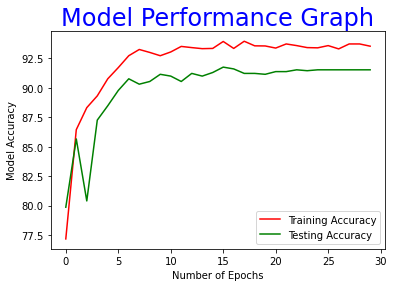

In [18]:
x = epochs
y = training_accuracy
z = testing_accuracy
plt.plot(x, y, color = 'r', label = 'Training Accuracy')
plt.plot(x, z, color = 'g', label = 'Testing Accuracy')
plt.legend()

#Naming the x and y axes & Title
plt.xlabel("Number of Epochs")
plt.ylabel("Model Accuracy")
plt.title("Model Performance Graph", fontsize = 24, color = 'blue')

plt.show()


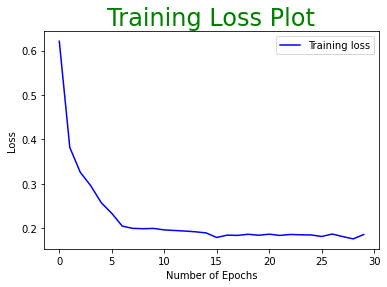

In [22]:
k = training_loss
plt.plot(x,k, color = 'b', label = 'Training loss')
plt.legend()

plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Plot", fontsize = 24, color = 'green')
plt.show()